# Bosques aleatorios

por Mónica Tatiana Gutierrez Ballen

version 1.0, Agosto 2021

This notebook is licensed under a [Creative Commons Attribution-ShareAlike 3.0 Unported License](http://creativecommons.org/licenses/by-sa/3.0/deed.en_US). Special thanks goes to [Rick Muller](http://www.cs.sandia.gov/~rmuller/), Sandia National Laboratories

¿Por qué estamos aprendiendo sobre ensamblaje?

- Método muy popular para mejorar el rendimiento predictivo de los modelos de aprendizaje automático
- Proporciona una base para entender modelos más sofisticados

# Parte 1: Construcción y ajuste de árboles de decisión



In [ ]:
import pandas as pd
import numpy as np

# read in the data
url = 'https://raw.githubusercontent.com/albahnsen/PracticalMachineLearningClass/master/datasets/hitters.csv'
hitters = pd.read_csv(url)

# remove rows with missing values
hitters.dropna(inplace=True)
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [ ]:
# encode categorical variables as integers
hitters['League'] = pd.factorize(hitters.League)[0]
hitters['Division'] = pd.factorize(hitters.Division)[0]
hitters['NewLeague'] = pd.factorize(hitters.NewLeague)[0]
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,0,0,632,43,10,475.0,0
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,1,0,880,82,14,480.0,1
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,0,1,200,11,3,500.0,0
4,321,87,10,39,42,30,2,396,101,12,48,46,33,0,1,805,40,4,91.5,0
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,1,0,282,421,25,750.0,1


In [ ]:
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

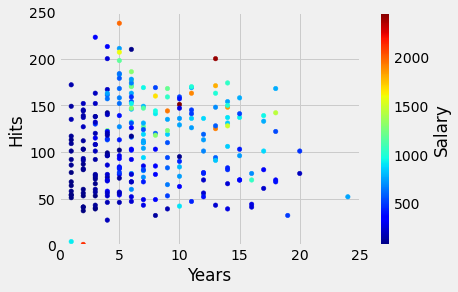

In [ ]:
# scatter plot of Years versus Hits colored by Salary
hitters.plot(kind='scatter', x='Years', y='Hits', c='Salary', colormap='jet', xlim=(0, 25), ylim=(0, 250))

In [ ]:
# define features: exclude career statistics (which start with "C") and the response (Salary)
feature_cols = hitters.columns[hitters.columns.str.startswith('C') == False].drop('Salary')
feature_cols

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'League',
       'Division', 'PutOuts', 'Assists', 'Errors', 'NewLeague'],
      dtype='object')

In [ ]:
hitters.Salary.describe()

count     263.000000
mean      535.925882
std       451.118681
min        67.500000
25%       190.000000
50%       425.000000
75%       750.000000
max      2460.000000
Name: Salary, dtype: float64

In [ ]:
# define X and y
X = hitters[feature_cols]
y = (hitters.Salary > 425).astype(int)

In [ ]:
X.columns

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'League',
       'Division', 'PutOuts', 'Assists', 'Errors', 'NewLeague'],
      dtype='object')

# Parte 2: Bosques aleatorios

Los bosques aleatorios son una **ligera variación de los árboles en bagging** que tiene un rendimiento aún mejor:

- Exactamente igual que el bagging, creamos un conjunto de árboles de decisión utilizando muestras del conjunto de entrenamiento.
- Sin embargo, al construir cada árbol, cada vez que se considera una división, se elige una **muestra aleatoria de m características** como candidatas a la división del **conjunto completo de p características**. La división sólo puede utilizar **una de esas m características**.
    - Se elige una nueva muestra aleatoria de características para **cada árbol en cada división**.
    - Para la **clasificación**, m suele ser la raíz cuadrada de p.
    - Para la **regresión**, m suele elegirse entre p/3 y p.

¿Qué sentido tiene?

- Supongamos que hay **una característica muy fuerte** en el conjunto de datos. Cuando se utilizan árboles empaquetados, la mayoría de los árboles utilizarán esa característica como la división superior, dando como resultado un conjunto de árboles similares que están **altamente correlacionados**.
- El promedio de las cantidades altamente correlacionadas no reduce significativamente la varianza (que es el objetivo del bagging).
- Al excluir aleatoriamente las características candidatas de cada división, **Random Forests "descorrelaciona" los árboles**, de modo que el proceso de promediación puede reducir la varianza del modelo resultante.


# Predicción del salario con un bosque aleatorio

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
clf = RandomForestClassifier()
clf

RandomForestClassifier()

In [ ]:
pd.Series(cross_val_score(clf, X, y, cv=10)).describe()

count    10.000000
mean      0.847721
std       0.044894
min       0.769231
25%       0.846154
50%       0.851852
75%       0.884615
max       0.888889
dtype: float64

### Ajuste de n_estimadores

Un parámetro de ajuste importante es el **número de estimadores**, que es el número de árboles que deben crecer. Debe ser un valor lo suficientemente grande como para que el error parezca "estabilizarse".

In [ ]:
# list of values to try for n_estimators
estimator_range = range(10, 310, 10)

# list to store the average Accuracy for each value of n_estimators
accuracy_scores = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for estimator in estimator_range:
    clf = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

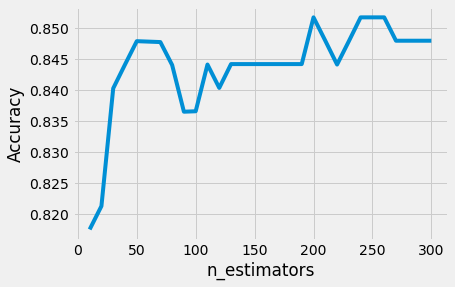

In [ ]:
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

### Ajuste de las características máximas

El otro parámetro de ajuste importante es **máximo de características**, que es el número de características que deben considerarse en cada división.

In [ ]:
# list of values to try for max_features
feature_range = range(1, len(feature_cols)+1)

# list to store the average Accuracy for each value of max_features
accuracy_scores = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for feature in feature_range:
    clf = RandomForestClassifier(n_estimators=200, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

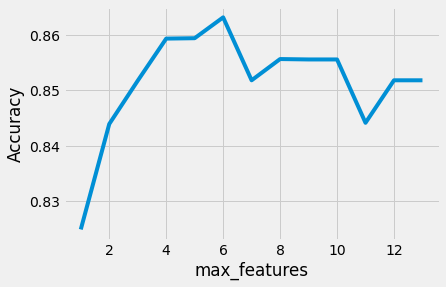

In [ ]:
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

### Ajuste de un bosque aleatorio con los mejores parámetros

In [ ]:
# max_features=6 is best and n_estimators=200 is sufficiently large
clf = RandomForestClassifier(n_estimators=200, max_features=6, random_state=1, n_jobs=-1)
clf.fit(X, y)

RandomForestClassifier(max_features=6, n_estimators=200, n_jobs=-1,
                       random_state=1)

In [ ]:
# compute feature importances
pd.DataFrame({'feature':feature_cols, 'importance':clf.feature_importances_}).sort_values('importance')

,feature,importance
8,Division,0.006081
7,League,0.008834
12,NewLeague,0.009709
11,Errors,0.032638
10,Assists,0.040503
2,HmRun,0.047118
9,PutOuts,0.051506
0,AtBat,0.078822
3,Runs,0.080185
5,Walks,0.082160


## Comparación de los bosques aleatorios con los árboles de decisión

**Ventajas de los bosques aleatorios**

- El rendimiento es competitivo con los mejores métodos de aprendizaje supervisado
- Proporciona una estimación más fiable de la importancia de las características
- Permite estimar el error fuera de la muestra sin utilizar la división entrenamiento/prueba o la validación cruzada

**Desventajas de los bosques aleatorios**

- Menos interpretable
- Son más lentos de entrenar
- Más lentos de predecir
